# Logistic Regression Baseline Model Development
The purpose of this notebook is to explore preprocessing techniques beyond the simple data cleaning formalized in the notebook "EDA" (!!!hyperlink this!!!). 

My main goal is to discover the best sampling method to address the class imbalance present in the target variable.

I will also prototype various hyper parameter settings. 

In [1]:
from preprocessor import data_cleaner

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score,cross_val_predict


In [2]:
# import and define training data. See preprocessor.py file for details on data_cleaner()
X_train, y_train = data_cleaner("../data/train.csv.zip")

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Age                                103904 non-null  int64  
 1   Flight Distance                    103904 non-null  int64  
 2   Inflight wifi service              103904 non-null  int64  
 3   Departure/Arrival time convenient  103904 non-null  int64  
 4   Ease of Online booking             103904 non-null  int64  
 5   Gate location                      103904 non-null  int64  
 6   Food and drink                     103904 non-null  int64  
 7   Online boarding                    103904 non-null  int64  
 8   Seat comfort                       103904 non-null  int64  
 9   Inflight entertainment             103904 non-null  int64  
 10  On-board service                   103904 non-null  int64  
 11  Leg room service                   1039

## Develop baseline model

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.metrics import plot_confusion_matrix,confusion_matrix,classification_report, roc_curve,auc

In [5]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train,y_train)

y_train_pred = cross_val_predict(logreg,X_train,y_train)

train_score = cross_val_score(logreg,X_train,y_train_pred,scoring='f1')

In [6]:
train_score.mean()

0.9848444640204921

In [7]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     84923
           1       0.77      0.69      0.73     18981

    accuracy                           0.91    103904
   macro avg       0.85      0.82      0.83    103904
weighted avg       0.90      0.91      0.90    103904



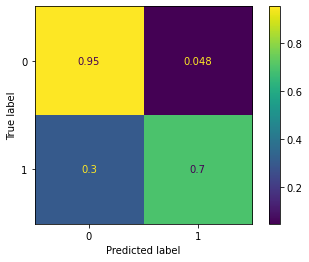

In [8]:
plot_confusion_matrix(logreg,X_train,y_train,normalize='true')
plt.show()

In [9]:
# Calculate the probability scores of each point in the training set
y_train_score = logreg.decision_function(X_train)

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

Training AUC: 0.9471988366981169


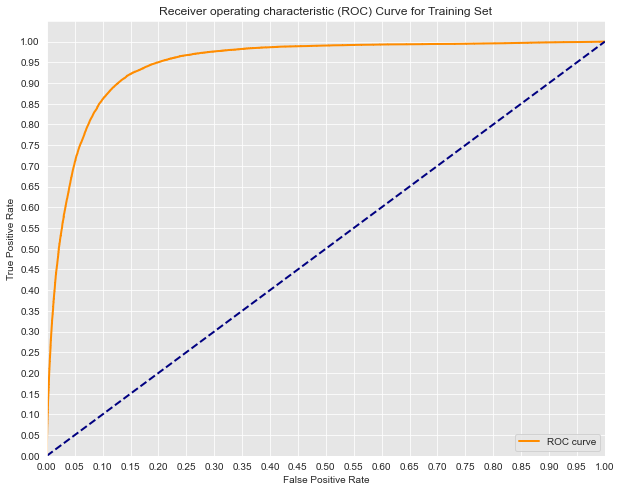

In [10]:
# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# ROC curve for training set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

## Prototype sampling methods
- SMOTE (synthetic over sampling)
- Tomek Links (under sampling against decision boundary)
- Near Miss (distance based under sampling)
- Edited Nearest Neighbors (under samplin against decision boundary)
- SMOTETomek (SMOTE/Tomek Link ensemble)
- SMOETENN (SMOTE/Edited Nearest Neighbors Ensemble)

### SMOTE

##### resample data

In [11]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset weights:', y_train.value_counts(normalize=True))
print('Original dataset size:',len(y_train))
print('\nResample dataset weights', y_smote.value_counts(normalize=True))
print('Resample dataset size:', len(y_smote))

Original dataset weights: 0    0.817322
1    0.182678
Name: disloyal Customer, dtype: float64
Original dataset size: 103904

Resample dataset weights 1    0.5
0    0.5
Name: disloyal Customer, dtype: float64
Resample dataset size: 169846


#### fit estimator

In [12]:
logreg_smote = LogisticRegressionCV(solver='liblinear',n_jobs=3)
logreg_smote.fit(X_smote,y_smote)

smote_train_pred = cross_val_predict(logreg_smote,X_smote,y_smote,n_jobs=3)

smote_train_score = cross_val_score(logreg_smote,X_smote,smote_train_pred,scoring='f1',n_jobs=3)
print(smote_train_score.mean())

0.9871648588461615


#### plot confusion matrix

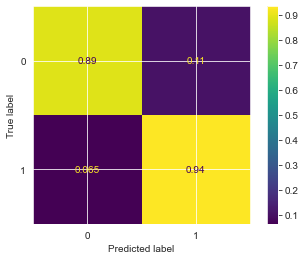

In [13]:
plot_confusion_matrix(logreg_smote,X_smote,y_smote,normalize='true')
plt.show()

#### print classification report

In [14]:
smote_report = classification_report(y_smote,smote_train_pred,output_dict=True)
smote_report = pd.DataFrame(smote_report).iloc[:,0:3]
smote_report

,0,1,accuracy
precision,0.922345,0.895953,0.908723
recall,0.892597,0.924850,0.908723
f1-score,0.907227,0.910172,0.908723
support,84923.000000,84923.000000,0.908723


#### calculate ROC AUC

In [15]:
# Calculate the probability scores of each point in the training set
y_smote_score = logreg_smote.decision_function(X_smote)
# Calculate the fpr, tpr, and thresholds for the training set
smote_fpr, smote_tpr, smote_thresholds = roc_curve(y_smote, y_smote_score)
print('Training AUC: {}'.format(auc(smote_fpr, smote_tpr)))

Training AUC: 0.964708301163559


### Tomek Links

#### resample data

In [16]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X_train, y_train)

print('Original dataset weights:', y_train.value_counts(normalize=True))
print('Original dataset size:',len(y_train))
print('\nResample dataset weights', y_tl.value_counts(normalize=True))
print('Resample dataset size:', len(y_tl))

Original dataset weights: 0    0.817322
1    0.182678
Name: disloyal Customer, dtype: float64
Original dataset size: 103904

Resample dataset weights 0    0.809029
1    0.190971
Name: disloyal Customer, dtype: float64
Resample dataset size: 99392


#### fit estimator

In [17]:
logreg_tl = LogisticRegression(solver='liblinear')
logreg_tl.fit(X_tl,y_tl)

tl_train_pred = cross_val_predict(logreg_tl,X_tl,y_tl,n_jobs=3)

tl_train_score = cross_val_score(logreg_tl,X_tl,y_tl,n_jobs=3,scoring='f1')
print(tl_train_score.mean())

0.7469474086997104


#### plot confusion matrix

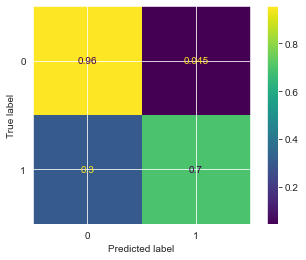

In [18]:
plot_confusion_matrix(logreg_tl,X_tl,y_tl,normalize='true')
plt.show()

#### print classification report

In [19]:
tomek_report = classification_report(y_tl,tl_train_pred,output_dict=True)
tomek_report = pd.DataFrame(tomek_report).iloc[:,0:3]
tomek_report

,0,1,accuracy
precision,0.934277,0.780713,0.907377
recall,0.952519,0.716137,0.907377
f1-score,0.943310,0.747032,0.907377
support,80411.000000,18981.000000,0.907377


#### calculate ROC AUC

In [20]:
# Calculate the probability scores of each point in the training set
y_tomek_score = logreg_smote.decision_function(X_tl)
# Calculate the fpr, tpr, and thresholds for the training set
tl_fpr , tl_tpr, tomek_thresholds = roc_curve(y_tl, y_tomek_score)
print('Training AUC: {}'.format(auc(tl_fpr, tl_tpr)))

Training AUC: 0.9430969178470339


### Near Miss

#### resample the data

In [21]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(sampling_strategy='all')
X_nm, y_nm = nm.fit_resample(X_train,y_train)

print('Original dataset weights:', y_train.value_counts(normalize=True))
print('Original dataset size:',len(y_train))
print('\nResample dataset weights', y_nm.value_counts(normalize=True))
print('Resample dataset size:', len(y_nm))

Original dataset weights: 0    0.817322
1    0.182678
Name: disloyal Customer, dtype: float64
Original dataset size: 103904

Resample dataset weights 1    0.5
0    0.5
Name: disloyal Customer, dtype: float64
Resample dataset size: 37962


#### fit estimator

In [22]:
logreg_nm = LogisticRegressionCV(solver='liblinear',n_jobs=3)
logreg_nm.fit(X_nm,y_nm)

nm_train_pred = cross_val_predict(logreg_nm,X_nm,y_nm,n_jobs=3)

nm_train_score = cross_val_score(logreg_nm,X_nm,y_nm,n_jobs=3,scoring='f1')
print(nm_train_score.mean())

0.8709056208353145


#### plot confusion matrix

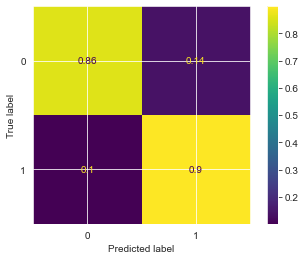

In [23]:
plot_confusion_matrix(logreg_nm,X_nm,y_nm,normalize='true')
plt.show()

#### print classification report

In [24]:
nm_report = classification_report(y_nm,nm_train_pred,output_dict=True)
nm_report = pd.DataFrame(nm_report).iloc[:,0:3]
nm_report

,0,1,accuracy
precision,0.876349,0.865908,0.871055
recall,0.864022,0.878089,0.871055
f1-score,0.870142,0.871956,0.871055
support,18981.000000,18981.000000,0.871055


#### calculate ROC AUC

In [25]:
# Calculate the probability scores of each point in the training set
y_nm_score  = logreg_nm.decision_function(X_nm)
# Calculate the fpr, tpr, and thresholds for the training set
nm_fpr , nm_tpr, nm_thresholds = roc_curve(y_nm, y_nm_score )
print('Training AUC: {}'.format(auc(nm_fpr, nm_tpr)))

Training AUC: 0.9499228653368943


### Edited Nearest Neighbors

#### resample the data

In [42]:
from imblearn.under_sampling import EditedNearestNeighbours
ENN = EditedNearestNeighbours(sampling_strategy='majority')
X_enn, y_enn = ENN.fit_resample(X_train,y_train)

print('Original dataset weights:', y_train.value_counts(normalize=True))
print('Original dataset size:',len(y_train))
print('\nResample dataset weights', y_enn.value_counts(normalize=True))
print('Resample dataset size:', len(y_enn))

Original dataset weights: 0    0.817322
1    0.182678
Name: disloyal Customer, dtype: float64
Original dataset size: 103904

Resample dataset weights 0    0.760619
1    0.239381
Name: disloyal Customer, dtype: float64
Resample dataset size: 79292


#### fit estimator

In [43]:
logreg_ENN = LogisticRegression(solver='liblinear')
logreg_ENN.fit(X_enn,y_enn)

enn_train_pred = cross_val_predict(logreg_ENN,X_enn,y_enn,n_jobs=3)

enn_train_score = cross_val_score(logreg_ENN,X_enn,y_enn,n_jobs=3,scoring='f1')
print(enn_train_score.mean())

0.8329351715136429


#### plot confusion matrix

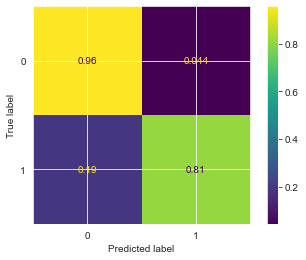

In [44]:
plot_confusion_matrix(logreg_ENN,X_enn,y_enn,normalize='true')
plt.show()

#### print classification matrix

In [45]:
enn_report = classification_report(y_enn,enn_train_pred,output_dict=True)
enn_report = pd.DataFrame(enn_report).iloc[:,0:3]
enn_report

,0,1,accuracy
precision,0.942915,0.850206,0.921606
recall,0.954735,0.816343,0.921606
f1-score,0.948788,0.832930,0.921606
support,60311.000000,18981.000000,0.921606


#### calculate ROC AUC

In [46]:
# Calculate the probability scores of each point in the training set
y_enn_score  = logreg_nm.decision_function(X_enn)
# Calculate the fpr, tpr, and thresholds for the training set
enn_fpr , enn_tpr, enn_thresholds = roc_curve(y_enn, y_enn_score )
print('Training AUC: {}'.format(auc(enn_fpr, enn_tpr)))

Training AUC: 0.7811875601429572


### SMOTETomek

#### resample the data

In [26]:
from imblearn.combine import SMOTETomek
SMOTek = SMOTETomek(sampling_strategy='all',smote=smote,tomek=tl,n_jobs=3)
X_smotek, y_smotek = SMOTek.fit_resample(X_train,y_train)

print('Original dataset weights:', y_train.value_counts(normalize=True))
print('Original dataset size:',len(y_train))
print('\nResample dataset weights', y_smotek.value_counts(normalize=True))
print('Resample dataset size:', len(y_smotek))

Original dataset weights: 0    0.817322
1    0.182678
Name: disloyal Customer, dtype: float64
Original dataset size: 103904

Resample dataset weights 1    0.501296
0    0.498704
Name: disloyal Customer, dtype: float64
Resample dataset size: 169407


#### fit estimator

In [27]:
logreg_SMOTek = LogisticRegression(solver='liblinear')
logreg_SMOTek.fit(X_smotek,y_smotek)

smotek_train_pred = cross_val_predict(logreg_SMOTek,X_smotek,y_smotek,n_jobs=3)

smotek_train_score = cross_val_score(logreg_SMOTek,X_smotek,y_smotek,n_jobs=3,scoring='f1')
print(smotek_train_score.mean())

0.9097072061431886


#### plot confusion matrix

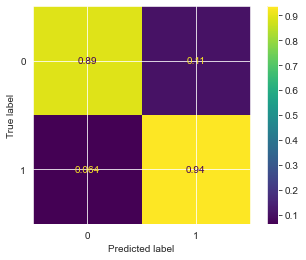

In [28]:
plot_confusion_matrix(logreg_SMOTek,X_smotek,y_smotek,normalize='true')
plt.show()

#### print classification report

In [29]:
smotek_report = classification_report(y_nm,nm_train_pred,output_dict=True)
smotek_report = pd.DataFrame(smotek_report).iloc[:,0:3]
smotek_report

,0,1,accuracy
precision,0.876349,0.865908,0.871055
recall,0.864022,0.878089,0.871055
f1-score,0.870142,0.871956,0.871055
support,18981.000000,18981.000000,0.871055


#### calculate ROC AUC

In [30]:
# Calculate the probability scores of each point in the training set
y_smotek_score  = logreg_SMOTek.decision_function(X_smotek)
# Calculate the fpr, tpr, and thresholds for the training set
smotek_fpr , smotek_tpr, smotek_thresholds = roc_curve(y_smotek, y_smotek_score )
print('Training AUC: {}'.format(auc(smotek_fpr, smotek_tpr)))

Training AUC: 0.9648654510764577


### SMOTENN

#### resmaple the data

In [31]:
from imblearn.combine import SMOTEENN
SMN = SMOTEENN(sampling_strategy='all',smote=smote)
X_smn, y_smn = SMN.fit_resample(X_train,y_train)

print('Original dataset weights:', y_train.value_counts(normalize=True))
print('Original dataset size:',len(y_train))
print('\nResample dataset weights', y_smn.value_counts(normalize=True))
print('Resample dataset size:', len(y_smn))

Original dataset weights: 0    0.817322
1    0.182678
Name: disloyal Customer, dtype: float64
Original dataset size: 103904

Resample dataset weights 1    0.602699
0    0.397301
Name: disloyal Customer, dtype: float64
Resample dataset size: 131608


#### fit estimator

In [32]:
logreg_SMOTENN = LogisticRegression(solver='liblinear')
logreg_SMOTENN.fit(X_smn,y_smn)

smn_train_pred = cross_val_predict(logreg_SMOTENN,X_smn,y_smn,n_jobs=3)

smn_train_score = cross_val_score(logreg_SMOTENN,X_smn,y_smn,n_jobs=3,scoring='f1')
print(smn_train_score.mean())

0.9519658319518236


#### plot confusion matrix

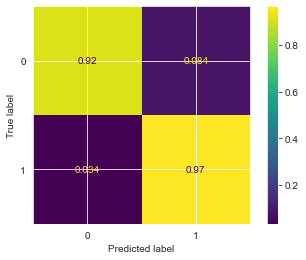

In [33]:
plot_confusion_matrix(logreg_SMOTENN,X_smn,y_smn,normalize='true')
plt.show()

#### print classification report

In [34]:
SMOTENN_report = classification_report(y_smn,smn_train_pred,output_dict=True)
SMOTENN_report = pd.DataFrame(SMOTENN_report).iloc[:,0:3]
SMOTENN_report

,0,1,accuracy
precision,0.936053,0.946080,0.942177
recall,0.917113,0.958699,0.942177
f1-score,0.926486,0.952348,0.942177
support,52288.000000,79320.000000,0.942177


#### calculate ROC AUC

In [35]:
# Calculate the probability scores of each point in the training set
SMOTENN_score  = logreg_SMOTENN.decision_function(X_smn)
# Calculate the fpr, tpr, and thresholds for the training set
smotenn_fpr , smotenn_tpr, smotenn_thresholds = roc_curve(y_smn, SMOTENN_score)
print('Training AUC: {}'.format(auc(smotenn_fpr, smotenn_tpr)))

Training AUC: 0.9837459830105778
